In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import joblib


In [2]:
# Load dataset
df = pd.read_csv("student_lifestyle_dataset.csv")
df.head()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


In [3]:
# Display basic information
df_info = df.info()
df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB


In [4]:
# Numbers of rows and columns
df_shape = df.shape
df_shape

(2000, 8)

In [5]:
# Descriptive statistics for numeric features
df.describe()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,1000.500000,7.475800,1.990100,7.501250,2.704550,4.32830,3.115960
std,577.494589,1.423888,1.155855,1.460949,1.688514,2.51411,0.298674
min,1.000000,5.000000,0.000000,5.000000,0.000000,0.00000,2.240000
25%,500.750000,6.300000,1.000000,6.200000,1.200000,2.40000,2.900000
50%,1000.500000,7.400000,2.000000,7.500000,2.600000,4.10000,3.110000
75%,1500.250000,8.700000,3.000000,8.800000,4.100000,6.10000,3.330000
max,2000.000000,10.000000,4.000000,10.000000,6.000000,13.00000,4.000000


In [6]:
# Count of missing values
df.isna().sum()

Student_ID                         0
Study_Hours_Per_Day                0
Extracurricular_Hours_Per_Day      0
Sleep_Hours_Per_Day                0
Social_Hours_Per_Day               0
Physical_Activity_Hours_Per_Day    0
GPA                                0
Stress_Level                       0
dtype: int64

Apparantly, there are no N/A in the datasets, which is great!! No need to clean it

# Data Visualizations

<Figure size 1400x1000 with 0 Axes>

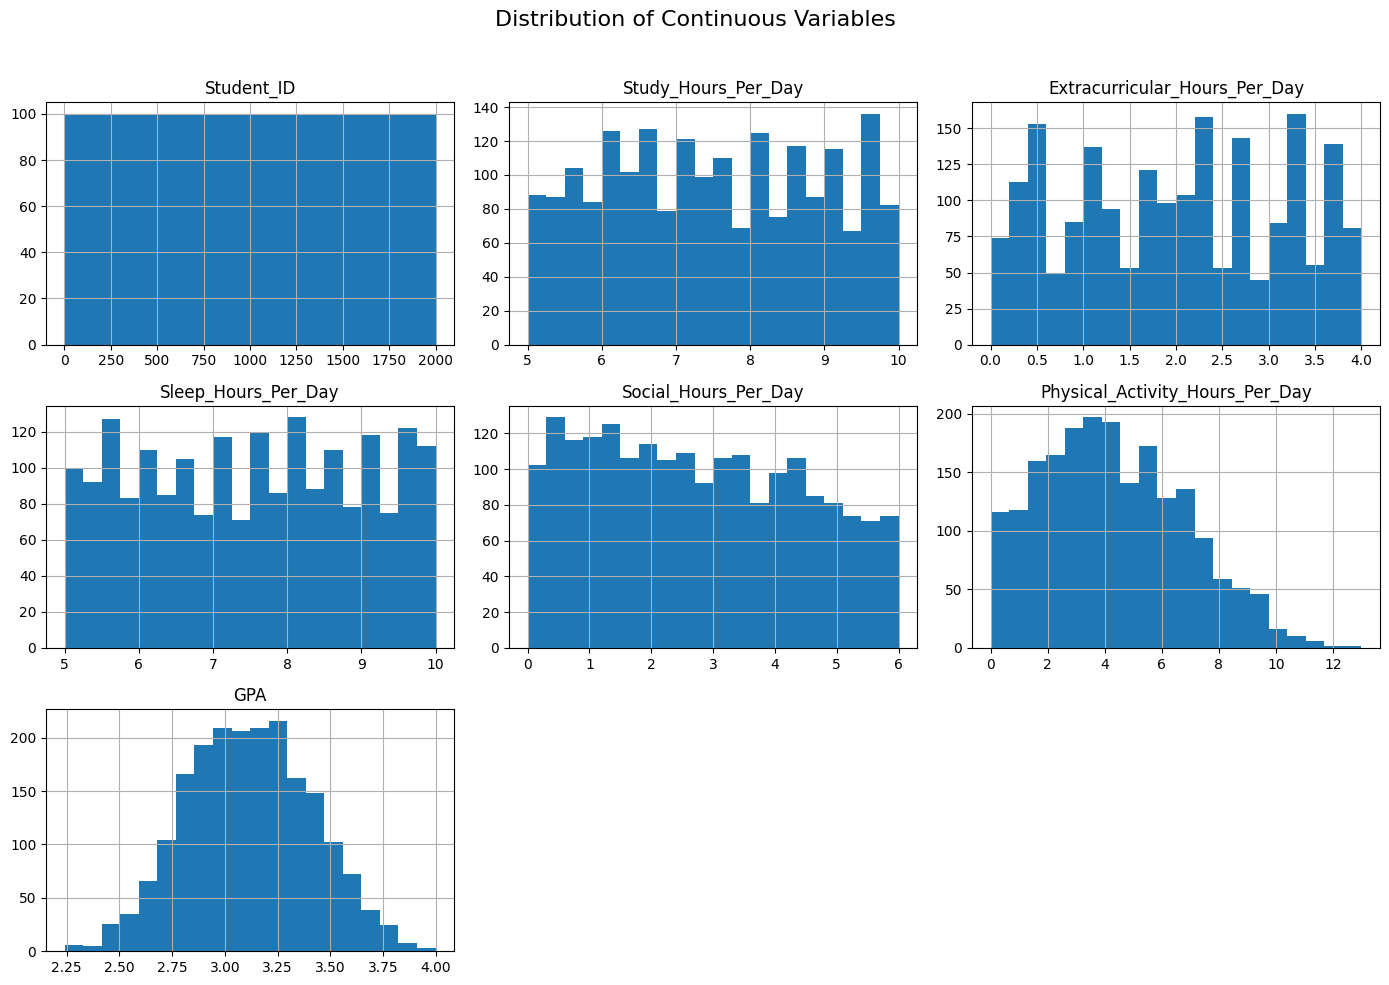

In [7]:
# Distribution of numerical features
plt.figure(figsize=(14, 10))
df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Distribution of Continuous Variables", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

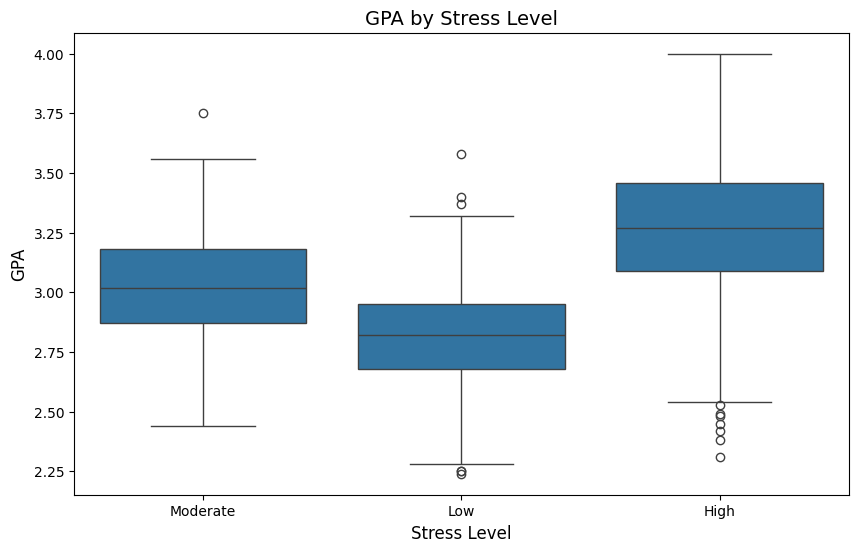

In [8]:
# Boxplot of GPA by Stress Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stress_Level', y='GPA', data=df)
plt.title('GPA by Stress Level', fontsize=14)
plt.xlabel('Stress Level', fontsize=12)
plt.ylabel('GPA', fontsize=12)
plt.show()

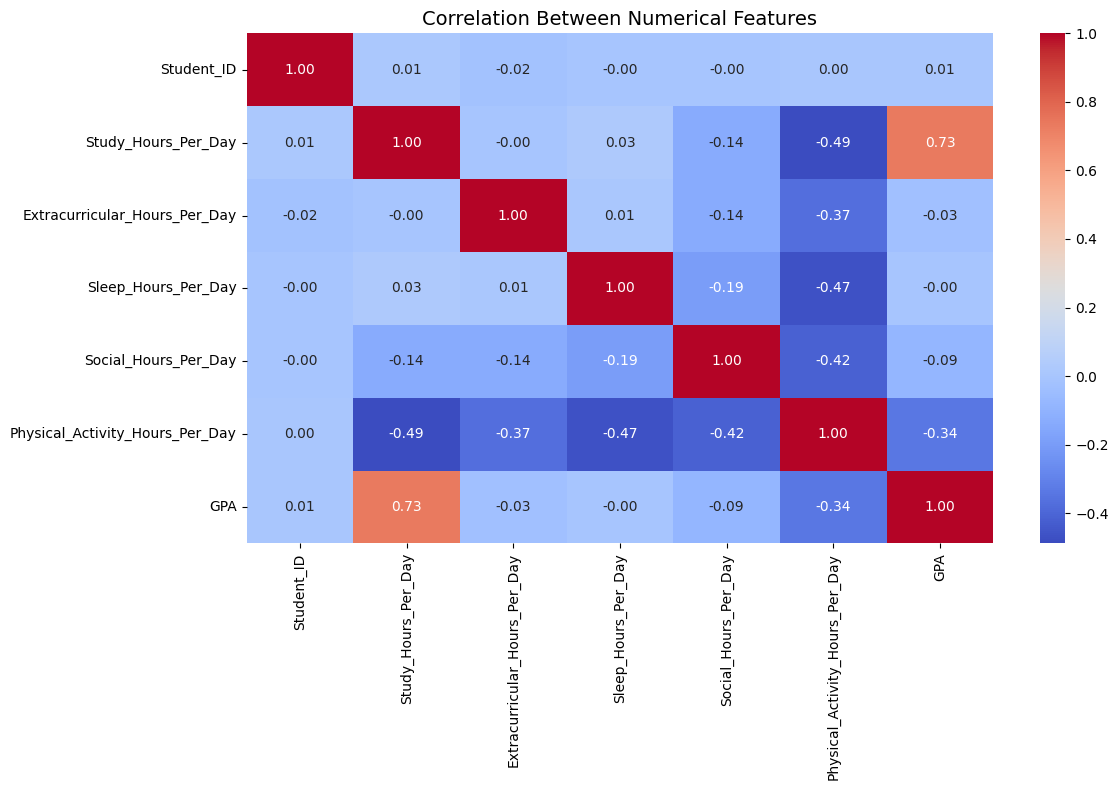

In [9]:
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include='number')

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

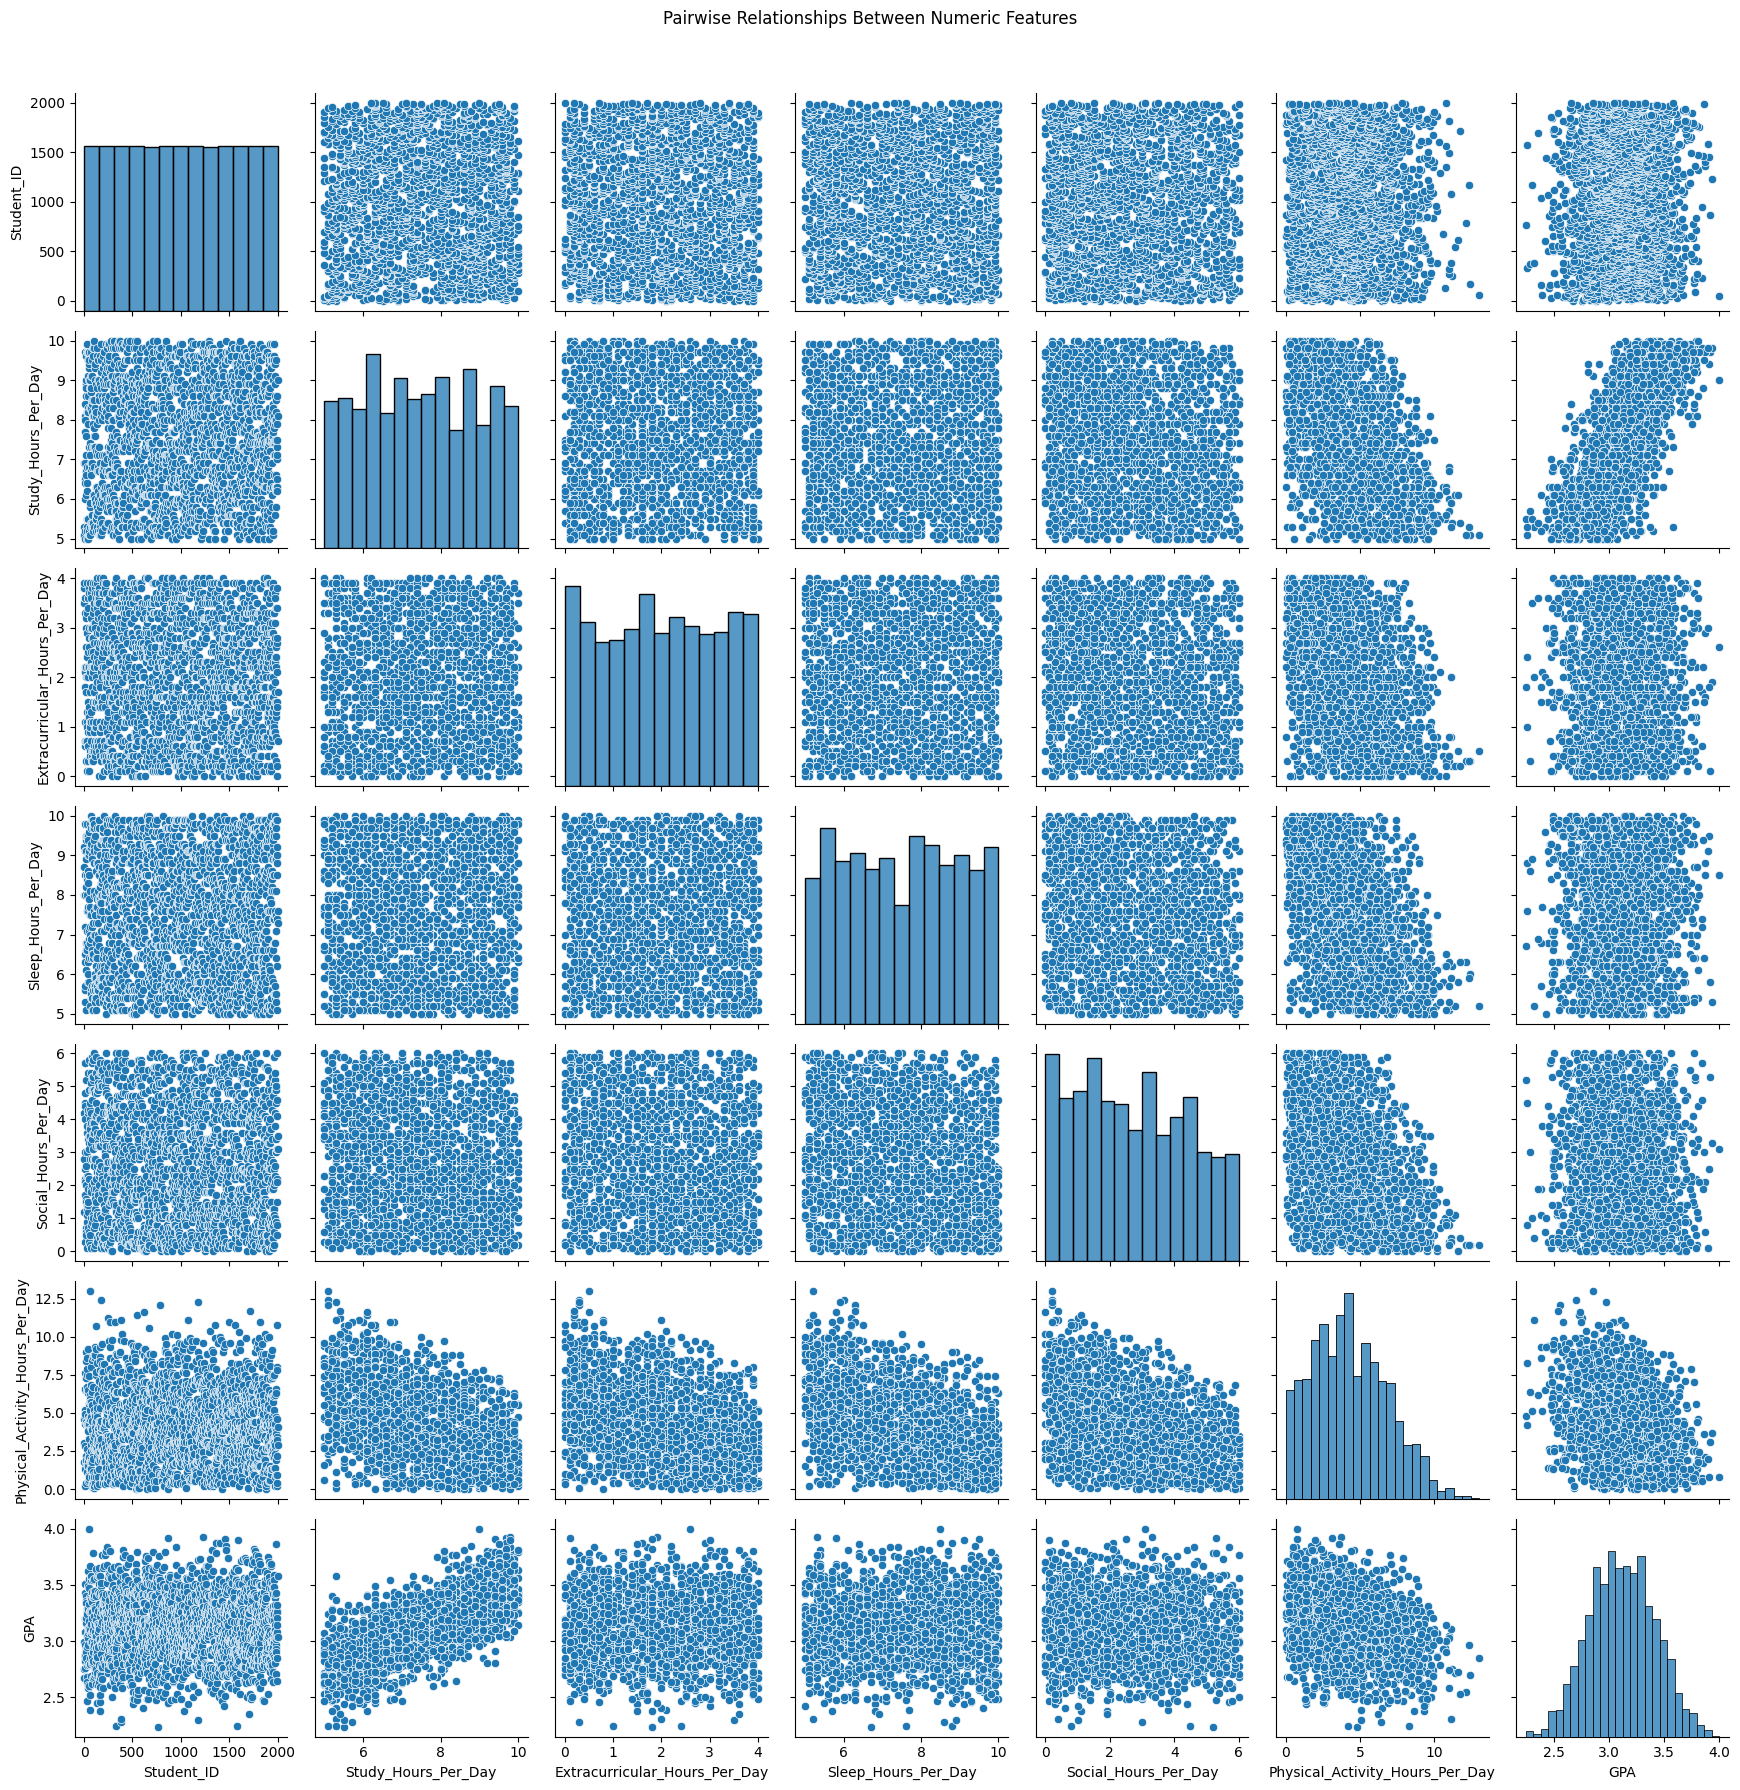

In [10]:
# Pairplot of numeric variables to detect potential linear relationships
pairplot = sns.pairplot(numeric_df)
plt.suptitle("Pairwise Relationships Between Numeric Features", y=1.02)
plt.tight_layout()
plt.show()

Study Hours vs GPA
- You can see a clear upward trend: students who study more tend to have higher GPA.
- This is a positive linear correlation and will likely be an important predictor for ML.

Sleep Hours vs GPA
- There's a mild positive pattern: more sleep may be slightly associated with better GPA. However, it's more scattered than study hours.

Social Hours / Extracurricular Hours vs GPA
- Both show a slightly negative or neutral pattern, meaning more social/extracurricular hours may not directly improve academic performance, or might have a trade-off with study time.

Physical Activity vs GPA
- This relationship is fairly scattered with no clear trend. It could be an important wellness factor, but not directly tied to GPA in this dataset.

Sleep vs Social Hours
- As sleep hours increase, social hours tend to decrease a bit — hinting at a possible time allocation trade-off.

Student_ID
- Student_ID has no meaningful correlation (as expected), so it should be dropped for ML.

## Create columns

In [11]:
# GPA to Letter Grade Mapping
def gpa_to_letter(gpa):
    if gpa >= 3.7:
        return 'A'
    elif gpa >= 3.3:
        return 'A-'
    elif gpa >= 3.0:
        return 'B+'
    elif gpa >= 2.7:
        return 'B'
    elif gpa >= 2.3:
        return 'B-'
    elif gpa >= 2.0:
        return 'C+'
    elif gpa >= 1.7:
        return 'C'
    elif gpa >= 1.3:
        return 'C-'
    elif gpa >= 1.0:
        return 'D+'
    elif gpa >= 0.7:
        return 'D'
    else:
        return 'F'

# Apply it
df['Letter_Grade'] = df['GPA'].apply(gpa_to_letter)

# Check
df[['GPA', 'Letter_Grade', 'Stress_Level']].head()


,GPA,Letter_Grade,Stress_Level
0,2.99,B,Moderate
1,2.75,B,Low
2,2.67,B-,Low
3,2.88,B,Moderate
4,3.51,A-,High


In [12]:
# Group letter grades for better prediction (balancing classes)
def group_letter_grade(letter):
    if letter in ['A', 'A-']:
        return 'A'
    elif letter in ['B+', 'B', 'B-']:
        return 'B'
    elif letter in ['C+', 'C', 'C-']:
        return 'C'
    else:
        return 'D/F'
# Apply it
df['Grouped_Letter_Grade'] = df['Letter_Grade'].apply(group_letter_grade)


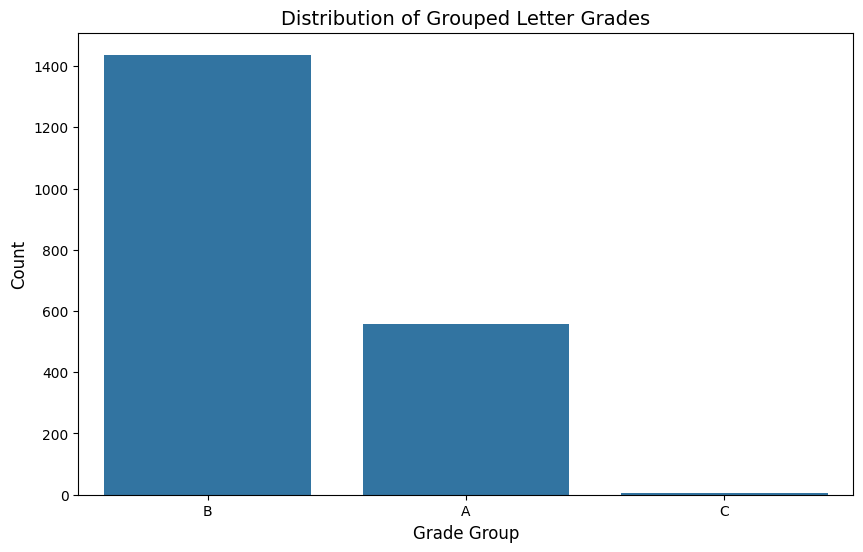

In [13]:
# Visualize distribution of grouped grades
plt.figure(figsize=(10, 6))
sns.countplot(x='Grouped_Letter_Grade', data=df)
plt.title('Distribution of Grouped Letter Grades', fontsize=14)
plt.xlabel('Grade Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Feature Engineering
We will scale the features to ensure all numerical values are on the same scale.

In [14]:
# Feature Engineering
# Features (drop GPA because it's now categorized)
X = df.drop(columns=['Student_ID', 'GPA', 'Letter_Grade', 'Grouped_Letter_Grade', 'Stress_Level'])
y = df[['Grouped_Letter_Grade', 'Stress_Level']]

In [15]:
# Create interaction features
# Study-Sleep interaction (quality study time)
X['Study_Sleep_Interaction'] = X['Study_Hours_Per_Day'] * X['Sleep_Hours_Per_Day']

# Social-to-Study ratio (balance indicator)
X['Social_Study_Ratio'] = X['Social_Hours_Per_Day'] / (X['Study_Hours_Per_Day'] + 1e-5)

# Total active time (energy expenditure)
X['Total_Activity_Hours'] = (
    X['Study_Hours_Per_Day'] + 
    X['Extracurricular_Hours_Per_Day'] + 
    X['Physical_Activity_Hours_Per_Day']
)


In [16]:
# Study efficiency (sleep-adjusted study potency)
X['Study_Efficiency'] = X['Study_Hours_Per_Day'] * (X['Sleep_Hours_Per_Day'] / 8)

# Balance metric (proper mix of activities)
X['Life_Balance'] = (
    (X['Sleep_Hours_Per_Day'] / 24) * 
    (X['Study_Hours_Per_Day'] / 24) * 
    (X['Physical_Activity_Hours_Per_Day'] / 24)
) * 100  # Scale up for readability

In [17]:
print(f"Original features: {df.columns.tolist()}")
print(f"Engineered features: {X.columns.tolist()}")

Original features: ['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'GPA', 'Stress_Level', 'Letter_Grade', 'Grouped_Letter_Grade']
Engineered features: ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Study_Sleep_Interaction', 'Social_Study_Ratio', 'Total_Activity_Hours', 'Study_Efficiency', 'Life_Balance']


# Data Splitting
We will split the dataset into training and testing sets.

In [18]:
# First encode categorical targets to numeric values for compatibility with all models
# Create label encoders for both targets
grade_encoder = LabelEncoder()
stress_encoder = LabelEncoder()

In [19]:
# Fit and transform the targets
grade_labels = grade_encoder.fit_transform(y['Grouped_Letter_Grade'])
stress_labels = stress_encoder.fit_transform(y['Stress_Level'])

In [20]:
# Store mapping for later interpretation
grade_mapping = {i: label for i, label in enumerate(grade_encoder.classes_)}
stress_mapping = {i: label for i, label in enumerate(stress_encoder.classes_)}

In [21]:
print("Grade mapping:", grade_mapping)
print("Stress level mapping:", stress_mapping)


Grade mapping: {0: 'A', 1: 'B', 2: 'C'}
Stress level mapping: {0: 'High', 1: 'Low', 2: 'Moderate'}


In [22]:
# Create a new DataFrame with encoded targets
y_encoded = pd.DataFrame({
    'Grouped_Letter_Grade': grade_labels,
    'Stress_Level': stress_labels
})

In [23]:
# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, 
    stratify=y_encoded['Grouped_Letter_Grade']  # Ensure balanced classes in train/test
)


In [24]:
# Scale features to normalize values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1600, 10)
Testing set shape: (400, 10)


# Model Training and Testing
We will train and test different supervised learning models to predict GPA.

In [26]:
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}


In [27]:
# Store results for comparison
results = {}

In [28]:
# Basic Models for Comparison
# Train and evaluate each model separately for comparison
for name, model in models.items():
    # Create multi-output classifier for each base model
    multi_model = MultiOutputClassifier(model)
    
    # Train
    multi_model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = multi_model.predict(X_test_scaled)
    
    # Evaluate
    print(f"\n===== {name} Results =====")
    
    # Grade accuracy
    grade_acc = accuracy_score(y_test['Grouped_Letter_Grade'], y_pred[:, 0])
    print(f"Letter Grade Accuracy: {grade_acc:.4f}")
    
    # Stress level accuracy
    stress_acc = accuracy_score(y_test['Stress_Level'], y_pred[:, 1])
    print(f"Stress Level Accuracy: {stress_acc:.4f}")
    
    # Overall accuracy (average)
    avg_acc = (grade_acc + stress_acc) / 2
    print(f"Overall Accuracy: {avg_acc:.4f}")
    
    # Store results
    results[name] = {
        'grade_acc': grade_acc,
        'stress_acc': stress_acc,
        'avg_acc': avg_acc,
        'model': multi_model
    }



===== Logistic Regression Results =====
Letter Grade Accuracy: 0.7425
Stress Level Accuracy: 0.9450
Overall Accuracy: 0.8438

===== Random Forest Results =====
Letter Grade Accuracy: 0.8150
Stress Level Accuracy: 1.0000
Overall Accuracy: 0.9075


c:\Users\hoang\Documents\MLSN\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost Results =====
Letter Grade Accuracy: 0.7950
Stress Level Accuracy: 1.0000
Overall Accuracy: 0.8975

===== Decision Tree Results =====
Letter Grade Accuracy: 0.7375
Stress Level Accuracy: 1.0000
Overall Accuracy: 0.8688

===== Gradient Boosting Results =====
Letter Grade Accuracy: 0.8175
Stress Level Accuracy: 1.0000
Overall Accuracy: 0.9087


In [29]:
# Enhanced Random Forest Model
# Create optimized Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,  # More trees for better accuracy
    max_depth=12,      # Deeper trees for more complex patterns
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,         # Use all cores
    class_weight='balanced'
)


In [30]:
# Create multi-output classifier
rf_multioutput = MultiOutputClassifier(rf_model, n_jobs=-1)

In [31]:
# Train model
rf_multioutput.fit(X_train_scaled, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=12,
                                                       min_samples_leaf=2,
                                                       min_samples_split=4,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42),
                      n_jobs=-1)

In [32]:
# Predict
rf_pred = rf_multioutput.predict(X_test_scaled)

In [33]:
# Grade accuracy
rf_grade_acc = accuracy_score(y_test['Grouped_Letter_Grade'], rf_pred[:, 0])
print(f"Letter Grade Accuracy: {rf_grade_acc:.4f}")

# Convert encoded predictions back to original labels for better visualization
predicted_grades = [grade_mapping[idx] for idx in rf_pred[:, 0]]
true_grades = [grade_mapping[idx] for idx in y_test['Grouped_Letter_Grade']]

# Grade details
print("\nLetter Grade Classification Report:")
print(classification_report(true_grades, predicted_grades, zero_division=0))

Letter Grade Accuracy: 0.8225

Letter Grade Classification Report:
              precision    recall  f1-score   support

           A       0.66      0.77      0.71       112
           B       0.90      0.85      0.87       287
           C       0.00      0.00      0.00         1

    accuracy                           0.82       400
   macro avg       0.52      0.54      0.53       400
weighted avg       0.83      0.82      0.83       400



- Some classes (like A and C+) have very few examples in the dataset.
- This can cause models to not predict these classes at all.

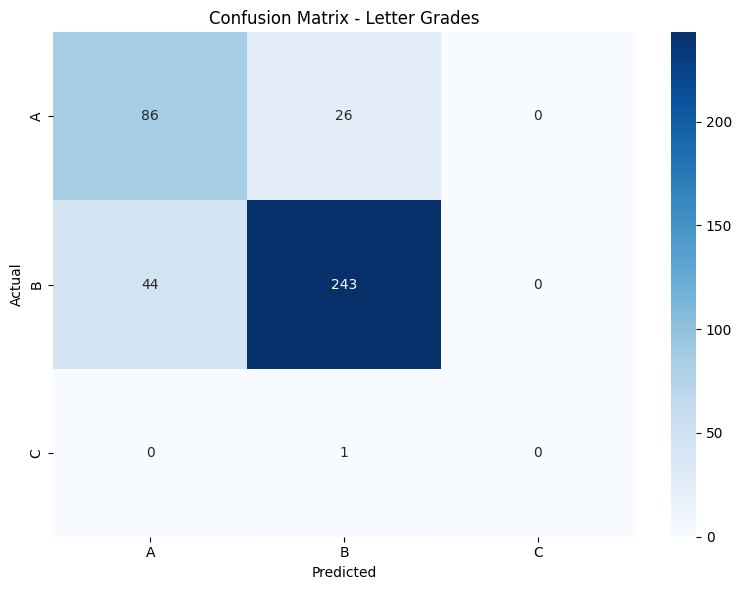

In [34]:
# Confusion matrix for grades
plt.figure(figsize=(8, 6))
grade_cm = confusion_matrix(true_grades, predicted_grades)
sns.heatmap(grade_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=sorted(set(true_grades)),
           yticklabels=sorted(set(true_grades)))
plt.title("Confusion Matrix - Letter Grades")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [35]:
# Stress level accuracy
rf_stress_acc = accuracy_score(y_test['Stress_Level'], rf_pred[:, 1])
print(f"\nStress Level Accuracy: {rf_stress_acc:.4f}")

# Convert encoded predictions back to original labels
predicted_stress = [stress_mapping[idx] for idx in rf_pred[:, 1]]
true_stress = [stress_mapping[idx] for idx in y_test['Stress_Level']]




Stress Level Accuracy: 1.0000


In [36]:
# Stress level details
print("\nStress Level Classification Report:")
print(classification_report(true_stress, predicted_stress, zero_division=0))


Stress Level Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       208
         Low       1.00      1.00      1.00        61
    Moderate       1.00      1.00      1.00       131

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



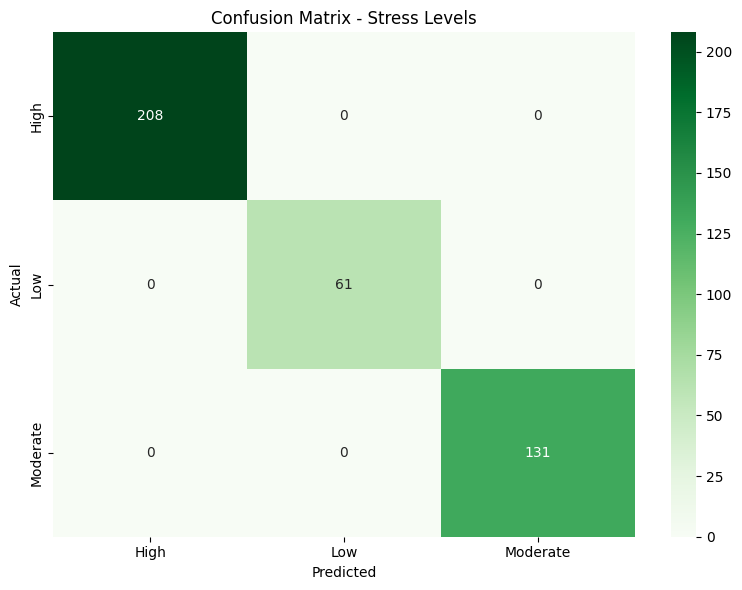

In [37]:
# Confusion matrix for stress
plt.figure(figsize=(8, 6))
stress_cm = confusion_matrix(true_stress, predicted_stress)
sns.heatmap(stress_cm, annot=True, fmt='d', cmap='Greens',
           xticklabels=sorted(set(true_stress)),
           yticklabels=sorted(set(true_stress)))
plt.title("Confusion Matrix - Stress Levels")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [38]:
# Overall accuracy
rf_avg_acc = (rf_grade_acc + rf_stress_acc) / 2
print(f"\nOverall Random Forest Accuracy: {rf_avg_acc:.4f}")


Overall Random Forest Accuracy: 0.9113


# Cross-Validation to Check Model Stability


In [39]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [40]:
# Cross-validation for Grouped_Letter_Grade
cv_scores_grade = cross_val_score(
    rf_model, X, y_encoded['Grouped_Letter_Grade'], cv=5, scoring='accuracy'
)

# Cross-validation for Stress_Level
cv_scores_stress = cross_val_score(
    rf_model, X, y_encoded['Stress_Level'], cv=5, scoring='accuracy'
)

print(f"CV Accuracy for Grouped Letter Grade: {cv_scores_grade.mean():.4f} ± {cv_scores_grade.std():.4f}")
print(f"CV Accuracy for Stress Level: {cv_scores_stress.mean():.4f} ± {cv_scores_stress.std():.4f}")

CV Accuracy for Grouped Letter Grade: 0.7950 ± 0.0152
CV Accuracy for Stress Level: 1.0000 ± 0.0000


In [41]:
# Check for signs of overfitting
train_acc = accuracy_score(y_train['Grouped_Letter_Grade'], rf_multioutput.predict(X_train_scaled)[:, 0])
test_acc = accuracy_score(y_test['Grouped_Letter_Grade'], rf_pred[:, 0])

In [42]:
print(f"\nTrain accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Difference (train-test): {train_acc - test_acc:.4f}")


Train accuracy: 0.9531
Test accuracy: 0.8225
Difference (train-test): 0.1306


# Create Model Wrapper Class 

In [43]:
# Define the StudentPredictionModel class to handle feature engineering and prediction
class StudentPredictionModel:
    def __init__(self, model, scaler, grade_encoder, stress_encoder, feature_names):
        self.model = model
        self.scaler = scaler
        self.grade_encoder = grade_encoder
        self.stress_encoder = stress_encoder
        self.grade_mapping = {i: label for i, label in enumerate(grade_encoder.classes_)}
        self.stress_mapping = {i: label for i, label in enumerate(stress_encoder.classes_)}
        self.feature_names = feature_names
    
    def predict(self, X_input):
        """
        Makes predictions from raw input features and returns human-readable labels
        
        Args:
            X_input: DataFrame with the base features (no need for engineered features)
        
        Returns:
            List of predictions with human-readable labels [letter_grade, stress_level]
        """
        # Engineer features if they're not already present
        X_processed = X_input.copy()
        
        # Create missing features
        if 'Study_Sleep_Interaction' not in X_processed.columns:
            # Study-Sleep interaction
            X_processed['Study_Sleep_Interaction'] = X_processed['Study_Hours_Per_Day'] * X_processed['Sleep_Hours_Per_Day']
            
            # Social-to-Study ratio
            X_processed['Social_Study_Ratio'] = X_processed['Social_Hours_Per_Day'] / (X_processed['Study_Hours_Per_Day'] + 1e-5)
            
            # Total active time
            X_processed['Total_Activity_Hours'] = (
                X_processed['Study_Hours_Per_Day'] + 
                X_processed['Extracurricular_Hours_Per_Day'] + 
                X_processed['Physical_Activity_Hours_Per_Day']
            )
            
            # Study efficiency
            X_processed['Study_Efficiency'] = X_processed['Study_Hours_Per_Day'] * (X_processed['Sleep_Hours_Per_Day'] / 8)
            
            # Balance metric
            X_processed['Life_Balance'] = (
                (X_processed['Sleep_Hours_Per_Day'] / 24) * 
                (X_processed['Study_Hours_Per_Day'] / 24) * 
                (X_processed['Physical_Activity_Hours_Per_Day'] / 24)
            ) * 100
        
        # Ensure columns are in the right order
        X_processed = X_processed[self.feature_names]
        
        # Scale the features
        X_scaled = self.scaler.transform(X_processed)
        
        # Make prediction
        y_encoded = self.model.predict(X_scaled)
        
        # Decode predictions
        grade_idx = int(y_encoded[0][0])
        stress_idx = int(y_encoded[0][1])
        
        letter_grade = self.grade_mapping[grade_idx]
        stress_level = self.stress_mapping[stress_idx]
        
        return [letter_grade, stress_level]

In [44]:
# Create a wrapper model
wrapped_model = StudentPredictionModel(
    rf_multioutput, 
    scaler,
    grade_encoder,
    stress_encoder,
    list(X.columns)
)


# Save the Model

In [45]:
# Save the model
joblib.dump(wrapped_model, "stacked_multioutput_predictor.pkl")
print("Model saved successfully!")

Model saved successfully!


In [46]:
# Test the Saved Model with a Sample Student
sample_student = pd.DataFrame({
    'Study_Hours_Per_Day': [7.0],
    'Extracurricular_Hours_Per_Day': [2.5],
    'Sleep_Hours_Per_Day': [7.5],
    'Social_Hours_Per_Day': [3.0],
    'Physical_Activity_Hours_Per_Day': [1.5]
})
sample_student

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day
0,7.0,2.5,7.5,3.0,1.5


In [47]:
# Load the saved model and predict
loaded_model = joblib.load("stacked_multioutput_predictor.pkl")
prediction = loaded_model.predict(sample_student)

In [48]:
print(f"Sample Student Input:")
print(sample_student.iloc[0][['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day']])
print(f"\nPredicted Letter Grade: {prediction[0]}")
print(f"Predicted Stress Level: {prediction[1]}")

Sample Student Input:
Study_Hours_Per_Day     7.0
Sleep_Hours_Per_Day     7.5
Social_Hours_Per_Day    3.0
Name: 0, dtype: float64

Predicted Letter Grade: B
Predicted Stress Level: Moderate
